# Sensitivity test - Different start times
## 72hr EQS - Neap tide


### This script can be used to find area exceedance of a tracer for 72hr EQS

To assess the long-term risks from Azamethiphos, the full treatment regime is modelled.
Tracer threshold - 40 ng/L.  
EQS area - 0.5 km2.  
The area of the chemical plume exceeding 40ng/l (72-hour EQS) is plotted.

In [65]:
import xarray as xr
import tfv.xarray
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import FixedLocator

User inputs

In [66]:
#Read the tuflowfv output
file_path = r"X:\Scratch1\aqua_dis_sensitivity_time_neap_002.nc"

#Specify the tracer threshold
my_thresholds = [40]


Read in Files

In [67]:
#Specify tracers
tracer_extract = ['TRACE_1','TRACE_2','TRACE_3','TRACE_4','TRACE_5']
tracer_names = ['minus 6 hours','minus 3 hours','0 hours','plus 3 hours','plus 6 hours'] 

#open the dataset as an array
fv_Neap = xr.open_dataset(file_path,decode_times=False).tfv

#Extract data at a certain depth range. Fox ex below will extract data for the top 4m.
fv_2d_trace_Neap =fv_Neap.get_sheet(tracer_extract,datum='depth',limits=(0,4))

...extracting sheet data: 100%|████████████████████████████████████████████████████| 1225/1225 [08:24<00:00,  2.43it/s]


In [69]:
# Specify start,end time and final treatment time
Neap_Start_Time = pd.to_datetime('2022-10-13 00:00:00', format='%Y-%m-%d %H:%M:%S')
#Neap_End_Time = pd.to_datetime('2018-11-24 10:00:00', format='%Y-%m-%d %H:%M:%S')
Neap_Final_Treatment = pd.to_datetime('2022-10-19 04:00:00', format='%Y-%m-%d %H:%M:%S')

Convert time to hours from start

In [70]:
# Create DataFrame
df_Neap = pd.DataFrame(index=fv_Neap['Time'])
df_Neap.index = df_Neap.index.strftime('%d/%m/%Y %H:%M:%S')
df_Neap.index = (pd.to_datetime(df_Neap.index,format='%d/%m/%Y %H:%M:%S') - Neap_Final_Treatment) / pd.Timedelta(hours=1)

Calculate area exceedance

In [71]:
# Calculate areas for each tracer
for tracer, tracer_name in zip(tracer_extract, tracer_names):
    ind = fv_2d_trace_Neap[tracer] > my_thresholds[0]
    area_filtered = fv_2d_trace_Neap['cell_A'].values[None,] * ind
    total_area = area_filtered.sum(dim='NumCells2D')
    total_area_km2 = total_area.values / 1000000
    total_area_km2 = total_area_km2.reshape(-1, 1)
    df_Neap[tracer_name] = total_area_km2

Plotting

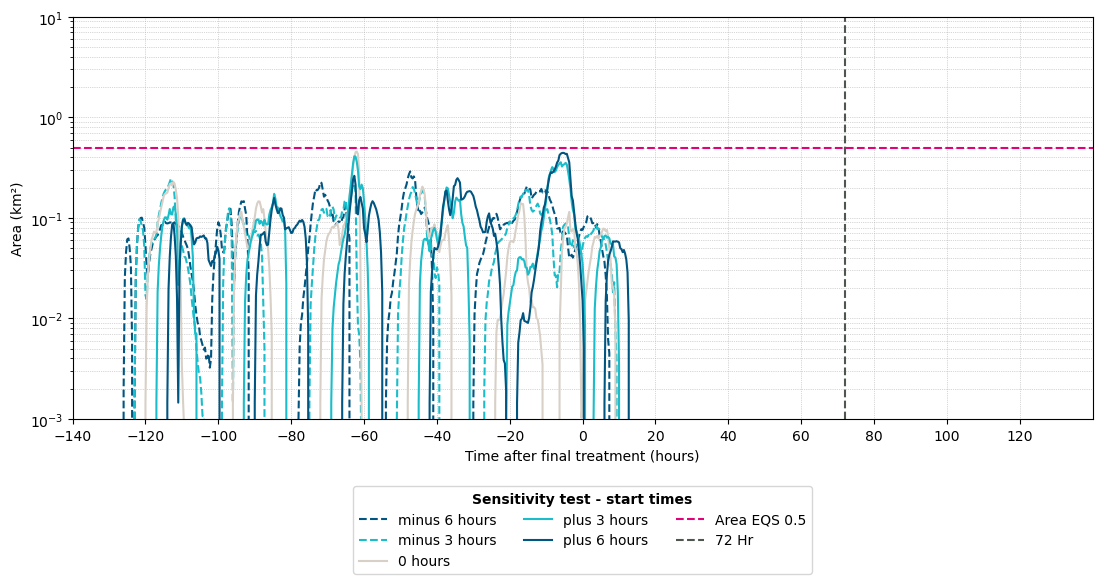

In [82]:
fig, ax = plt.subplots(figsize=(12, 6))
fig.subplots_adjust(left=0.1, right=0.95, top=0.95, bottom=0.28)

# Specify colors and line styles for each tracer
tracer_colors = ['#005581', '#1ABDC9', '#D8D0C7', '#1ABDC9', '#005581']
tracer_line_styles = ['--', '--', '-', '-', '-']

# Plot all five tracers as lines with specified colors and line styles
for tracer, tracer_name, color, linestyle in zip(tracer_extract, tracer_names, tracer_colors, tracer_line_styles):
    df_Neap[tracer_name].plot(ax=ax, logy=True, label=tracer_name, color=color, linestyle=linestyle)

ax.set_xlabel('Time after final treatment (hours)')
ax.set_ylabel('Area (km²)')
ax.set_ylim(0.001, 10)
ax.set_xlim(-140, 140)
ax.set_xticks(np.arange(-140, 140, 20))

# Add EQS lines
ax.hlines(y=0.5, xmin=-140, xmax=140, colors='#E20177', linestyles='dashed', label='Area EQS 0.5')
ax.vlines(x=72, ymin=0, ymax=10, colors='#4F5650', linestyles='dashed', label='72 Hr')

# Update the legend
legend = ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=3, title='Sensitivity test - start times')
plt.setp(legend.get_title(), weight='bold')

# Add minor gridlines for the logarithmic y-axis
ax.yaxis.grid(True, which='both', linestyle=':', linewidth=0.5)
ax.xaxis.grid(True, which='major', linestyle=':', linewidth=0.5)

plt.xticks(rotation=0)

# Save plot as PNG image with DPI of 300
fig.savefig('../figures/aqua_72hr_sensitivity_test_start_times.png', dpi=300)

plt.show()